In [ ]:
# importing the libraries
import numpy as np
import pandas as pd
import string
import re
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split as tts

nltk.download('punkt')

print("All the modules imported....")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


All the modules imported....


In [ ]:
pip install joblib

In [ ]:
import joblib

In [ ]:
train = pd.read_csv("/content/mtsamples.csv")
print('Dataset loaded....')

Dataset loaded....


In [ ]:
train.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
train.tail()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
4994,4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN
4998,4998,"Acute allergic reaction, etiology uncertain, ...",Allergy / Immunology,Allergy Evaluation Consult,"HISTORY: , A 34-year-old male presents today s...",NaN


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


In [ ]:
train.describe()

,Unnamed: 0
count,4999.000000
mean,2499.000000
std,1443.231328
min,0.000000
25%,1249.500000
50%,2499.000000
75%,3748.500000
max,4998.000000


In [ ]:
train.shape

(4999, 6)

In [ ]:
# preprocessing the data

def cleaning(text):
    text = str(text)
    text = text.lower()
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    clean = re.compile('<.*?>')
    text = re.sub(clean,'',text)
    text = pattern.sub('', text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)

    text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    text = ' '.join(words)
    return text

print("Cleaning is taking place....")
train['text_new'] = train['description'] + ' ' + train['sample_name'] + ' ' + train['transcription'] + ' ' + train['keywords']
train['text_new'] = train['text_new'].map(cleaning)
train["medical_specialty"] = train['medical_specialty'].map(cleaning)
print("Cleaning is done....")

Cleaning is taking place....
Cleaning is done....


In [ ]:
train["medical_specialty"].value_counts()

surgery                      1103
consult history and phy       516
cardiovascular pulmonary      372
orthopedic                    355
radiology                     273
general medicine              259
gastroenterology              230
neurology                     223
soap chart progress notes     166
obstetrics gynecology         160
urology                       158
discharge summary             108
ent otolaryngology             98
neurosurgery                   94
hematology oncology            90
ophthalmology                  83
nephrology                     81
emergency room reports         75
pediatrics neonatal            70
pain management                62
psychiatry psychology          53
office notes                   51
podiatry                       47
dermatology                    29
dentistry                      27
cosmetic plastic surgery       27
letters                        23
physical medicine rehab        21
sleep medicine                 20
endocrinology 

<Axes: xlabel='count', ylabel='medical_specialty'>

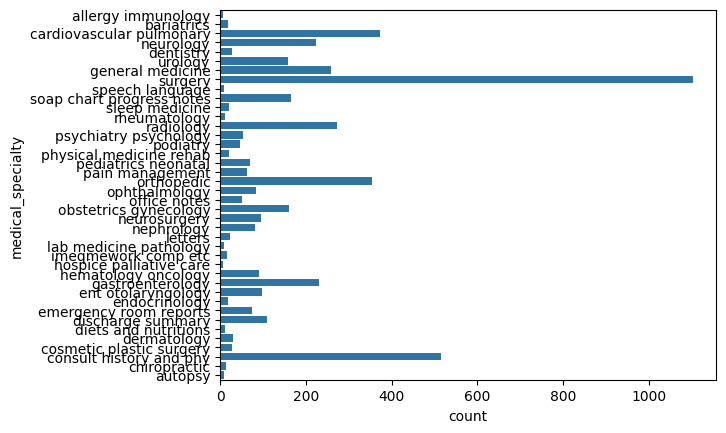

In [ ]:
sns.countplot(y='medical_specialty', data=train)

In [ ]:
train = train.drop(index=train[train['medical_specialty'] == 'allergy immunology'].index)
train = train.drop(index=train[train['medical_specialty'] == 'lab medicine pathology'].index)
train = train.drop(index=train[train['medical_specialty'] == 'autopsy'].index)
train = train.drop(index=train[train['medical_specialty'] == 'speech language'].index)
train = train.drop(index=train[train['medical_specialty'] == 'diets and nutritions'].index)
train = train.drop(index=train[train['medical_specialty'] == 'rheumatology'].index)
train = train.drop(index=train[train['medical_specialty'] == 'chiropractic'].index)
train = train.drop(index=train[train['medical_specialty'] == 'imeqmework comp etc'].index)
train = train.drop(index=train[train['medical_specialty'] == 'bariatrics'].index)
train = train.drop(index=train[train['medical_specialty'] == 'endocrinology'].index)
train = train.drop(index=train[train['medical_specialty'] == 'sleep medicine'].index)
train = train.drop(index=train[train['medical_specialty'] == 'physical medicine rehab'].index)
train = train.drop(index=train[train['medical_specialty'] == 'letters'].index)
train = train.drop(index=train[train['medical_specialty'] == 'dentistry'].index)
train = train.drop(index=train[train['medical_specialty'] == 'cosmetic plastic surgery'].index)
train = train.drop(index=train[train['medical_specialty'] == 'dermatology'].index)
train = train.drop(index=train[train['medical_specialty'] == 'hospice palliative care'].index)
train = train.drop(index=train[train['medical_specialty'] == 'soap chart progress notes'].index)
train = train.drop(index=train[train['medical_specialty'] == 'discharge summary'].index)
train = train.drop(index=train[train['medical_specialty'] == 'emergency room reports'].index)
train = train.drop(index=train[train['medical_specialty'] == 'office notes'].index)

In [ ]:
train["medical_specialty"].value_counts()

surgery                     1103
consult history and phy      516
cardiovascular pulmonary     372
orthopedic                   355
radiology                    273
general medicine             259
gastroenterology             230
neurology                    223
obstetrics gynecology        160
urology                      158
ent otolaryngology            98
neurosurgery                  94
hematology oncology           90
ophthalmology                 83
nephrology                    81
pediatrics neonatal           70
pain management               62
psychiatry psychology         53
podiatry                      47
Name: medical_specialty, dtype: int64

In [ ]:
train.shape

(4327, 7)

<Axes: xlabel='count', ylabel='medical_specialty'>

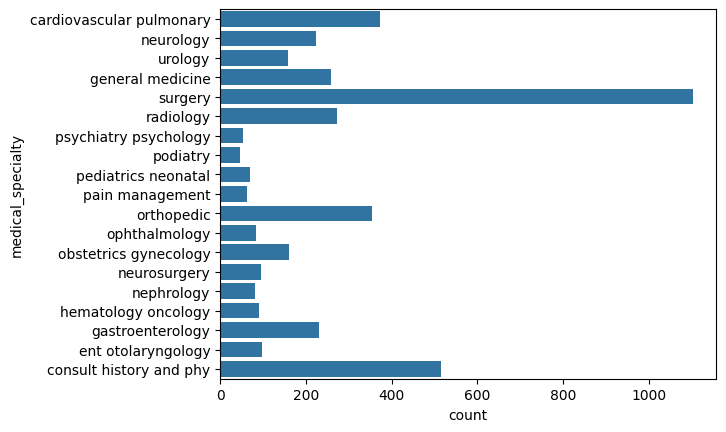

In [ ]:
sns.countplot(y='medical_specialty', data=train)

In [ ]:
train.shape

(4327, 7)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4327 entries, 3 to 4976
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4327 non-null   int64 
 1   description        4327 non-null   object
 2   medical_specialty  4327 non-null   object
 3   sample_name        4327 non-null   object
 4   transcription      4295 non-null   object
 5   keywords           3430 non-null   object
 6   text_new           4327 non-null   object
dtypes: int64(1), object(6)
memory usage: 270.4+ KB


In [ ]:
train.isna().sum()

Unnamed: 0             0
description            0
medical_specialty      0
sample_name            0
transcription         32
keywords             897
text_new               0
dtype: int64

In [ ]:
train=train.dropna()

In [ ]:
train.isna().sum()

Unnamed: 0           0
description          0
medical_specialty    0
sample_name          0
transcription        0
keywords             0
text_new             0
dtype: int64

In [ ]:
train.shape

(3398, 7)

In [ ]:
train["medical_specialty"].unique()

array(['cardiovascular pulmonary', 'urology', 'general medicine',
       'surgery', 'radiology', 'psychiatry psychology', 'podiatry',
       'pediatrics neonatal', 'pain management', 'orthopedic',
       'ophthalmology', 'obstetrics gynecology', 'neurosurgery',
       'neurology', 'nephrology', 'hematology oncology',
       'gastroenterology', 'ent otolaryngology',
       'consult history and phy'], dtype=object)

In [ ]:
value = {
'surgery':0,
'consult history and phy':1,
'cardiovascular pulmonary':2,
'orthopedic':3,
'radiology':4,
'general medicine':5,
'gastroenterology':6,
'neurology':7,
'obstetrics gynecology':8,
'urology':9,
'ent otolaryngology':10,
'neurosurgery':11,
'hematology oncology':12,
'ophthalmology':13,
'nephrology':14,
'pediatrics neonatal':15,
'pain management':16,
'psychiatry psychology':17,
'podiatry':18,
}

train['medical_specialty'] = train["medical_specialty"].map(value)

In [ ]:
value['podiatry']

18

In [ ]:
value['urology']

9

In [ ]:
train["medical_specialty"].unique()

array([ 2,  9,  5,  0,  4, 17, 18, 15, 16,  3, 13,  8, 11,  7, 14, 12,  6,
       10,  1])

In [ ]:
print('Formulating the dependent and independent variable....')
train = train[['text_new','medical_specialty']]
X = train['text_new'].values
y = train['medical_specialty'].values

print("Splitting the data into train and test....")
xtrain,xtest,ytrain,ytest = tts(X,y,test_size=0.2,random_state=42,stratify=y)
print("Splitting done....")
print("Total data points in Train data....", ytrain.shape[0])
print("Total data points in the Test data....", ytest.shape[0])

Formulating the dependent and independent variable....
Splitting the data into train and test....
Splitting done....
Total data points in Train data.... 2718
Total data points in the Test data.... 680


In [ ]:
# converting dependent variable into categorical variable
ytrainf = to_categorical(ytrain)
ytestf = to_categorical(ytest)

In [ ]:
# converting to text to sequences
tokenizer=Tokenizer(20000,lower=True,oov_token='UNK')
tokenizer.fit_on_texts(xtrain)
xtrain = tokenizer.texts_to_sequences(xtrain)
xtest = tokenizer.texts_to_sequences(xtest)

xtrain = pad_sequences(xtrain,maxlen=300,padding='post')
xtest = pad_sequences(xtest,maxlen=300,padding='post')
print("Data preprocessing is over....")

Data preprocessing is over....


In [ ]:
joblib.dump(tokenizer,"tokenfinal.pkl")

['tokenfinal.pkl']

In [ ]:
# making the model
print("Making the model....")
model = Sequential()
model.add(Embedding(20000,64,input_length=300))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(Dense(19,activation="softmax"))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print("Model making done....")
print(model.summary())

Making the model....
Model making done....
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           1280000   
                                                                 
 dropout (Dropout)           (None, 300, 64)           0         
                                                                 
 bidirectional (Bidirection  (None, 300, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense

In [ ]:
import keras
import tensorflow as tf

from tensorflow import keras

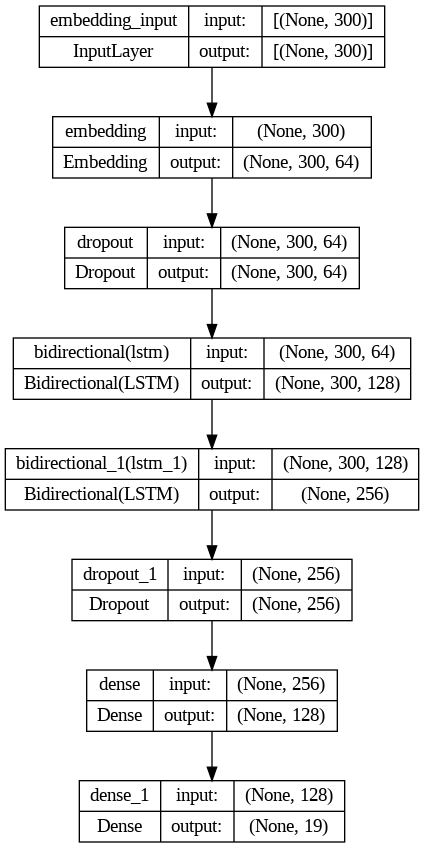

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
!nvidia-smi

Mon Apr  1 09:04:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0              30W /  70W |    139MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# fitting it into the data
print("Running the model....")
hist = model.fit(xtrain,ytrainf,epochs=500,validation_data=(xtest,ytestf))

Running the model....
Epoch 1/500
85/85 [==============================] - 28s 217ms/step - loss: 2.4687 - accuracy: 0.3190 - val_loss: 2.1919 - val_accuracy: 0.3647
Epoch 2/500
85/85 [==============================] - 17s 200ms/step - loss: 2.0432 - accuracy: 0.3937 - val_loss: 1.9227 - val_accuracy: 0.4397
Epoch 3/500
85/85 [==============================] - 12s 137ms/step - loss: 1.6341 - accuracy: 0.4790 - val_loss: 1.6925 - val_accuracy: 0.4500
Epoch 4/500
85/85 [==============================] - 9s 105ms/step - loss: 1.3492 - accuracy: 0.5548 - val_loss: 1.4964 - val_accuracy: 0.5309
Epoch 5/500
85/85 [==============================] - 10s 114ms/step - loss: 1.1734 - accuracy: 0.6207 - val_loss: 1.6007 - val_accuracy: 0.5338
Epoch 6/500
85/85 [==============================] - 7s 84ms/step - loss: 1.1545 - accuracy: 0.6416 - val_loss: 1.4609 - val_accuracy: 0.5603
Epoch 7/500
85/85 [==============================] - 7s 87ms/step - loss: 0.8009 - accuracy: 0.7458 - val_loss: 1.211

In [ ]:
print("Saving the model into the disk....")
model.save('medicalspecalty.h5')
print("Model saved into the disk....")

Saving the model into the disk....
Model saved into the disk....


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plotting the figures....
Figures saved in the disk....
Testing the model....
The result obtained is...

22/22 [==============================] - 2s 17ms/step


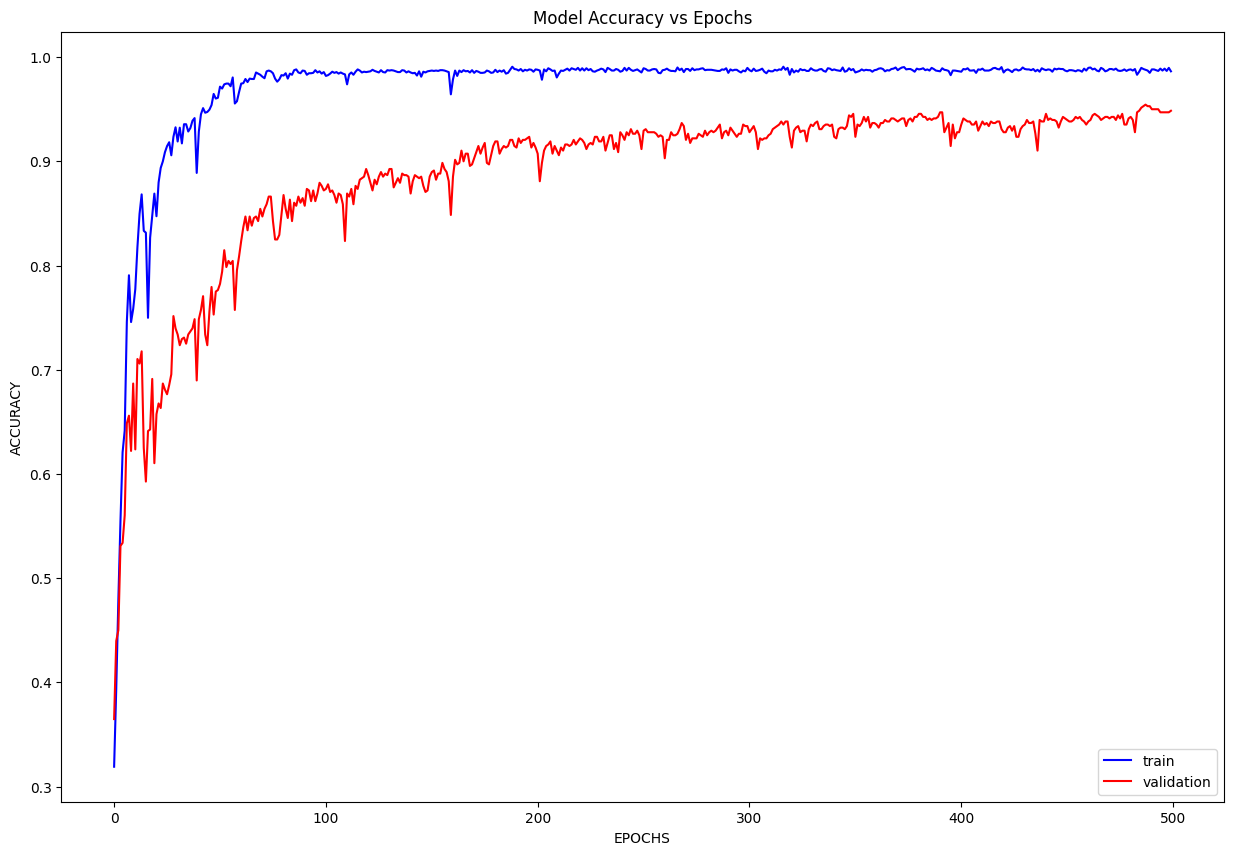

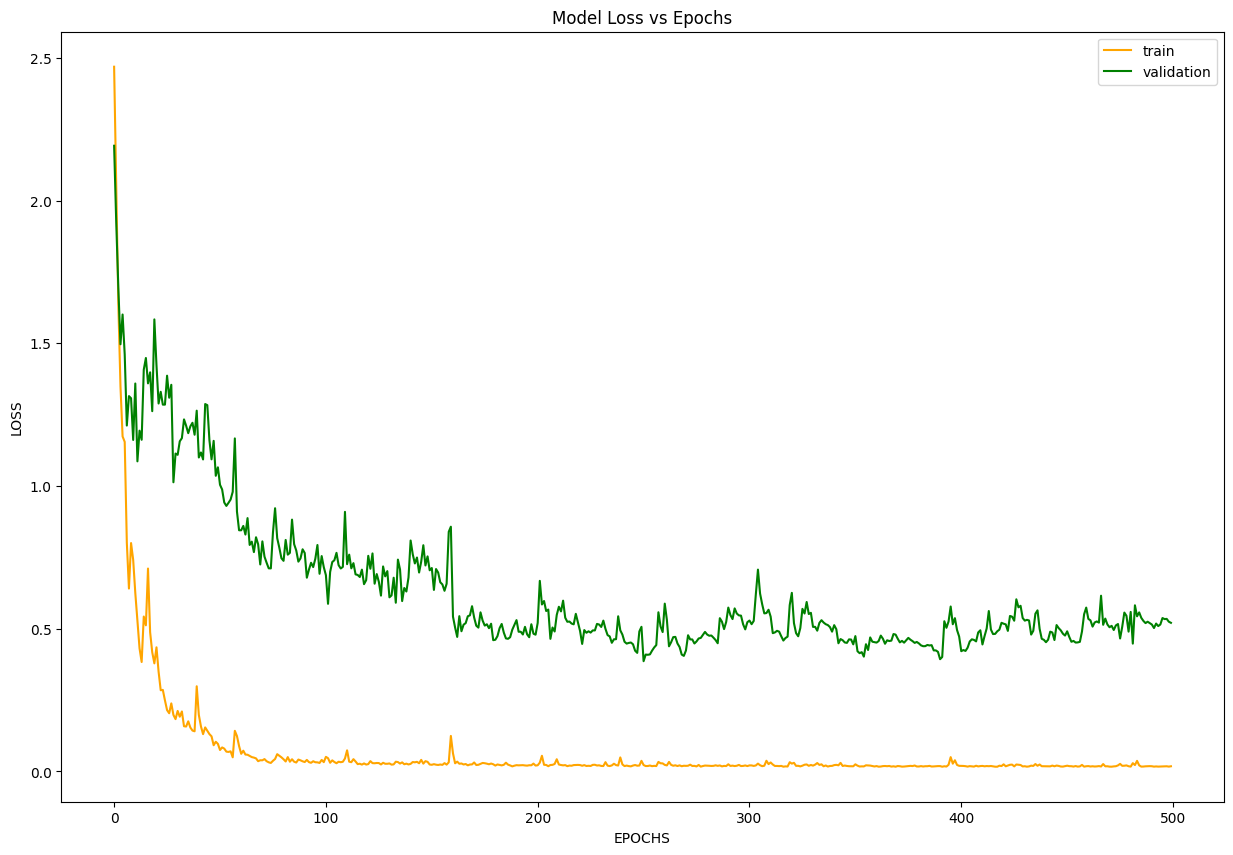

In [ ]:
# plotting the figures
print("Plotting the figures....")
plt.figure(figsize=(15,10))
plt.plot(hist.history['accuracy'],c='b',label='train')
plt.plot(hist.history['val_accuracy'],c='r',label='validation')
plt.title("Model Accuracy vs Epochs")
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend(loc='lower right')
plt.savefig('accuracy.jpg')


plt.figure(figsize=(15,10))
plt.plot(hist.history['loss'],c='orange',label='train')
plt.plot(hist.history['val_loss'],c='g',label='validation')
plt.title("Model Loss vs Epochs")
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.legend(loc='upper right')
plt.savefig('loss.jpg')
print("Figures saved in the disk....")

# testing the model
print("Testing the model....")
print("The result obtained is...\n")
model.evaluate(xtest,ytestf)

ypred = model.predict(xtest)
ypred = np.argmax(ypred,axis=1)

In [ ]:
print("Classification Report:\n",classification_report(ytest,ypred))
cf = confusion_matrix(ytest,ypred)
print("The confusion matrix is: \n",cf)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       0.93      0.89      0.91        47
           2       1.00      0.98      0.99        56
           3       0.97      1.00      0.98        61
           4       1.00      1.00      1.00        50
           5       0.81      0.90      0.85        29
           6       1.00      1.00      1.00        39
           7       1.00      0.94      0.97        34
           8       0.96      0.96      0.96        26
           9       0.96      0.93      0.95        28
          10       1.00      0.94      0.97        17
          11       0.94      0.94      0.94        16
          12       0.67      0.50      0.57        12
          13       0.93      0.88      0.90        16
          14       0.71      0.77      0.74        13
          15       0.31      0.50      0.38         8
          16       1.00      1.00      1.00        12
   

[ 6  5  1  1  8  4  6  0  0  7  2 15  8  0  8  0  0  0  3  0  6  0  3 12
  4  1  3 10  5  4  4  6  6  1  8  4  0  0  1  3  0  7  0  3  7  6  3  0
 14  4 12  2  4  2 13 15  4  0  6  7  0  0  3 10  0  2  3  0  6  4  3  0
  2  0  0  7  7 15  3 11  0  4  3  4  2  0  6  3  0 10 16  2  8  7  2  4
 10  1  0  7  0  1  9  6  0  9 11 12  4  0  0  0  0  0  3  2  2  3  0  1
  1  0  0  0  0  2  0  5  0  2  6  2  0  4  4  4  0  3  6 14  0  9  6 10
  0  2  0  3  0 13  0  1  0  0  0 13  0  2  0  4 10  0  4  6  2 18  2 13
 13 18 10  3  4  9  5  9 11  8  5  4  0  2  2  6  3  6 13  3  8  4  0  0
  0  1  0  0 14  2  1  0  3 11  1  2  6  3  9  2  4 13  3  9  2  6  0  2
  0  1  9  1  8  2 18  5  3  4  1  1 14  8  6  1  0 10  0  1  4  7  5  9
  0  0  4 18  3  8  0  0 13  3  9  2 12  0  0  0  0  1  9  0  1 15  0  6
  0  3  7  0 15  7  0  2  0 11 16  0  0 16  7  0  9 11  7  0 16  6  4 13
  0  3 13 10  0  5  4  4  9 15  9  6 12  5  0 18 10  2  9  2  3  2  0  1
  7  6 10  6  4  0  4 11  3 15  4  0  5 14  0  3  8

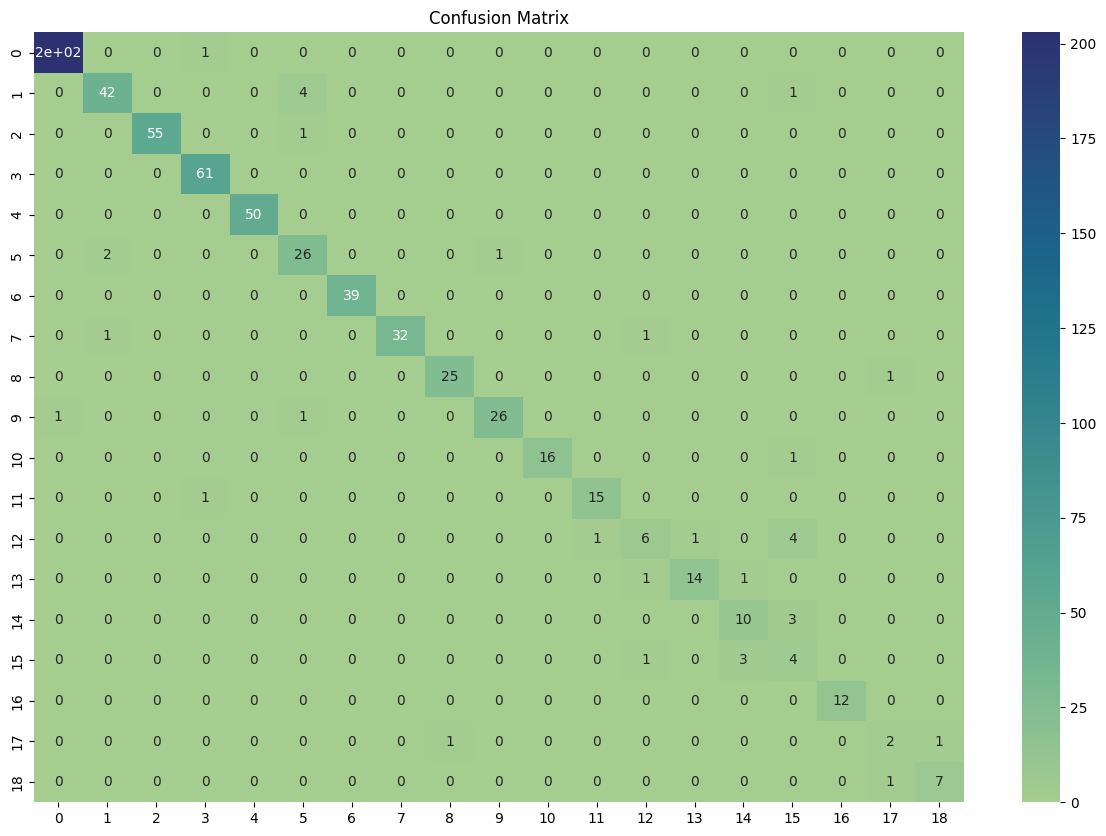

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(cf,annot=True,cmap='crest')
plt.title("Confusion Matrix")
plt.savefig("confusion.jpg")

print(ypred)

<Axes: >

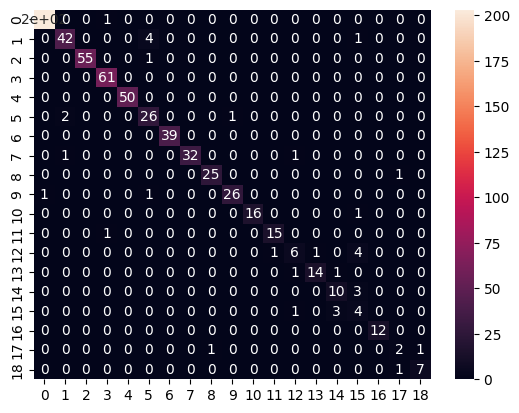

In [ ]:
sns.heatmap(cf, annot=True)

<Axes: >

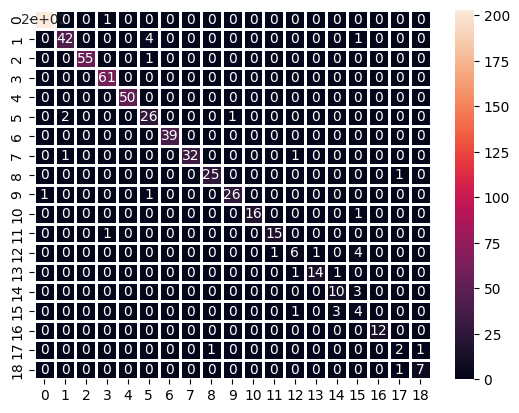

In [ ]:
sns.heatmap(cf, annot=True, linewidth=.75)

In [ ]:
from sklearn.utils.multiclass import unique_labels
unique_labels(ytest)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [ ]:
# combining labels with the confusion matrix

def plot(ytest,ypred):
  labels = unique_labels(ytest)
  column = [f'Predicted {label}' for label in labels]
  indices = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(ytest,ypred), columns=column, index=indices)

  return table

In [ ]:
plot(ytest,ypred)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9,Predicted 10,Predicted 11,Predicted 12,Predicted 13,Predicted 14,Predicted 15,Predicted 16,Predicted 17,Predicted 18
Actual 0,203,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Actual 1,0,42,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0
Actual 2,0,0,55,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Actual 3,0,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Actual 4,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Actual 5,0,2,0,0,0,26,0,0,0,1,0,0,0,0,0,0,0,0,0
Actual 6,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0
Actual 7,0,1,0,0,0,0,0,32,0,0,0,0,1,0,0,0,0,0,0
Actual 8,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,1,0
Actual 9,1,0,0,0,0,1,0,0,0,26,0,0,0,0,0,0,0,0,0


In [ ]:
# same plot as above but in heatmap

def plot2(ytest,ypred):
  labels = unique_labels(ytest)
  column = [f'Predicted {label}' for label in labels]
  indices = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(ytest,ypred), columns=column, index=indices)

  return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

<Axes: >

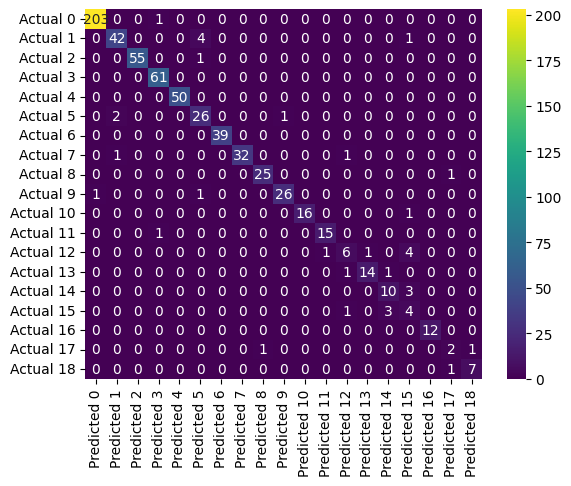

In [ ]:
plot2(ytest,ypred)

In [ ]:
model = keras.models.load_model('medicalspecalty.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           1280000   
                                                                 
 dropout (Dropout)           (None, 300, 64)           0         
                                                                 
 bidirectional (Bidirection  (None, 300, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
test = "I am having chest pain and also breathing problem"

In [ ]:
tokenizer = joblib.load('tokenfinal.pkl')
print("Data preprocessing is over....")

Data preprocessing is over....


In [ ]:
test = tokenizer.texts_to_sequences([test])

In [ ]:
test = pad_sequences(test,maxlen=300,padding='post')

In [ ]:
predict = model.predict([test])

1/1 [==============================] - 0s 31ms/step


In [ ]:
predict.shape

(1, 19)

In [ ]:
np.argmax(predict)

2

In [ ]:
value = {
0:'surgery',
1:'consult history and phy',
2:'cardiovascular pulmonary',
3:'orthopedic',
4:'radiology',
5:'general medicine',
6:'gastroenterology',
7:'neurology',
8:'obstetrics gynecology',
9:'urology',
10:'ent otolaryngology',
11:'neurosurgery',
12:'hematology oncology',
13:'ophthalmology',
14:'nephrology',
15:'pediatrics neonatal',
16:'pain management',
17:'psychiatry psychology',
18:'podiatry',
}

In [ ]:
value[2]

'cardiovascular pulmonary'

In [ ]:
prediction = value[np.argmax(predict)]
print(prediction)

cardiovascular pulmonary
